In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
categorical  = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [3]:
def get_data(fname):
    df = pd.read_parquet(fname)
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds() / 60 )
    df.loc[:, categorical] = df[categorical].astype(str)
    return df

In [4]:
def remove_outliers(df):    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    return df

In [5]:
df_train = get_data("data/yellow_tripdata_2022-01.parquet")
df_val = get_data("data/yellow_tripdata_2022-02.parquet")

In [6]:
print(f"Number of columns : {len(df_train.columns) - 1}") # remove the duration column that was added later
print(f"Standard deviation of duration: {df_train.duration.std()}")

Number of columns : 19
Standard deviation of duration: 46.44530513776802


In [7]:
orig_nrows = df_train.shape[0]
df_train = remove_outliers(df_train)
df_val = remove_outliers(df_val)
nrows = df_train.shape[0]
print(f"Fraction left after removing outliers : {(nrows * 100 / orig_nrows):.2f}%")

Fraction left after removing outliers : 98.28%


In [8]:
df_train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN,5.966667
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN,10.650000
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN,11.000000
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN,12.050000


In [9]:
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")

In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [11]:
X_train.shape, X_val.shape

((2421440, 516), (2918187, 516))

In [12]:
y_train = df_train["duration"].values
y_val = df_val["duration"].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared = False)

7.001496179429168

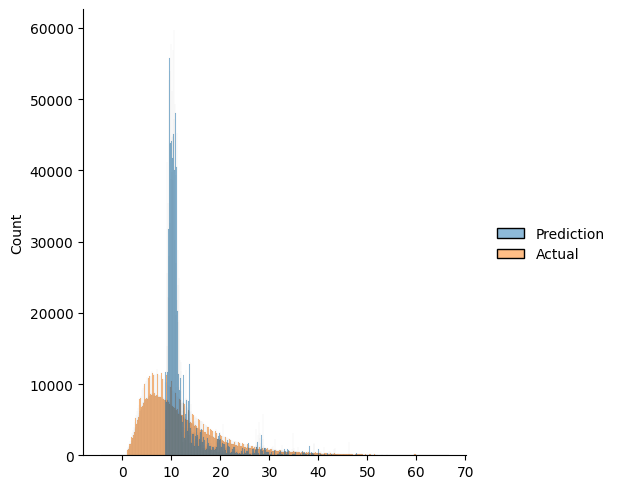

In [15]:
result_data = {"Prediction": y_pred, "Actual": y_train}
result_df = pd.DataFrame(result_data)
sns.displot(data=result_df)
plt.show()

In [16]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.795498346156581